In [1]:
# 기본 import 패키지
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
%matplotlib inline

### 커널 서포트 벡터 머신
커널 서포트 벡터 머신*kernelized support vector machines*은 선형 서포트 벡터 머신을 입력 데이터에서 단순한 초평면으로 정의되지 않는 더 복잡한 모델을 만들 수 있도록 확장한 것이다.

#### 선형 모델과 비선형 특성
직선과 초평면은 유연하지 못하여 저차원 데이터셋에서는 선형 모델이 매우 제한적이다. 선형 모델을 유연하게 만드는 방법중  하나는 특성끼리 곱하거나 거듭제곱하는 식으로 새로운 특성을 추가하는 것이다.

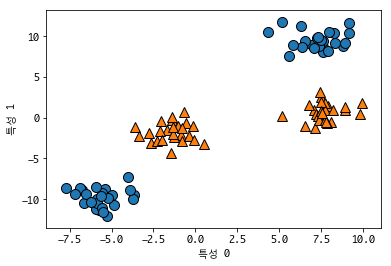

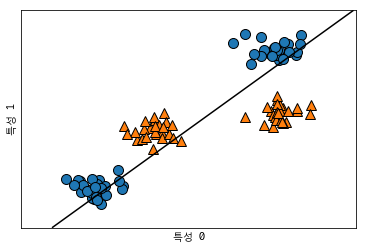

In [6]:
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

plt.show()

from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

선형 모델은 직선으로만 데이터를 나눌 수 있어 이런 데이터셋에는 잘 맞지 않는다.

두번째 특성을 제곱한 ${특성1}^2$을 새로운 특성으로 추가해 3차원 데이터 포인트로 표현한다.

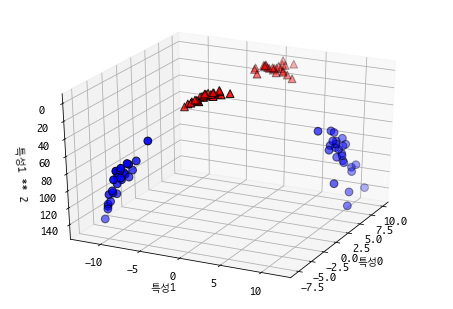

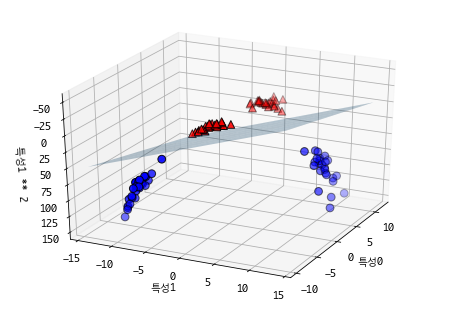

In [10]:
# 두 번째 특성을 제곱하여 추가합니다
X_new = np.hstack([X, X[:, 1:] ** 2])

from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()
# 3차원 그래프
ax = Axes3D(figure, elev=-152, azim=-26)
# y == 0 인 포인트를 먼저 그리고 그 다음 y == 1 인 포인트를 그립니다
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel("특성0")
ax.set_ylabel("특성1")
ax.set_zlabel("특성1 ** 2")

linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# 선형 결정 경계 그리기
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')

ax.set_xlabel("특성0")
ax.set_ylabel("특성1")
ax.set_zlabel("특성1 ** 2")

새로운 데이터셋에서는 평면을 사용해 두 클래스를 구분할 수 있다. 원래 특성으로 투영해보면 이 선형 SVM 모델은 선형이 아니라 타원에 가까운 모습이 된다.

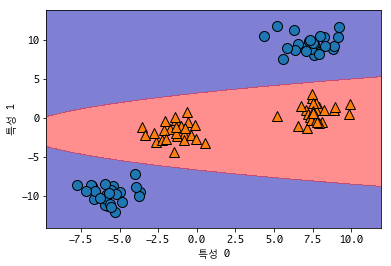

In [11]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

#### 커널 기법
비선형 특성을 추가하면 선형 모델이 강력해지지만 어떤 특성을 추가해야될지 모르고 많은 특성을 추가하면 연산 비용이 커진다. **커널 기법** *kernel trick*을 사용해 실제로 데이터를 확장하지 않고 확장된 특성에 대한 데이터 포인트들의 거리(스칼라 곱을 계산할 수 있다.

서포트 벡터 머신에서 데이터를 고차원 공간에 매핑하는데 많이 사용하는 방법은 두 가지이다.  
* 다항식 커널: 특성의 가능한 조합을 지정된 차수까지 모든 계산
* RBF*radial basis function* 커널: 가우시안*Gaussian* 커널이라고도 불린다. 차원이 무한한 특성 공간에 매핑한다. 모든 차수의 모든 다항식을 고려하는 것으로 이해하면 좋다. 지수 함수의 테일러 전개 때문에 특성의 중요도는 고차항이 될수록 줄어든다.

#### SVM 이해하기
SVM은 각 각 훈련 데이터 포인트가 클래스의 결정 경계를 구분하는데 얼마나 중요한지를 배운다. 일반적으로 결정 경계를 만드는데는 경계에 위치한 일부 훈련 데이터만 영향을 준다. 이런 데이터 포인트를 **서포트 벡터**라고 한다.

새로운 데이터에 대해 예측하려면 각 서포트 벡터와의 거리를 측정한다. 데이터 포인트 사이의 거리는 가우시안 커널에 의해 계산된다.
$$ k_{rbf} (x_1, x_2) = \exp(-\gamma \lVert x_1 - x_2 \rVert^2) $$
$x_1, x_2$: 데이터 포인트, $\lVert x_1 - x_2 \rVert$: 유클리드 거리, $\gamma$: 가우시안 커널의 폭을 제어하는 매개변수 

아래는 두 개의 클래스를 가진 2차원 forge 데이터셋의 SVM학습 결과이다. 결정 경계는 검은 실선, 서포트 벡터는 굵은 테두리로 처리했다. SVM은 매우 부드럽고 비선형인 경계를 만들었다.

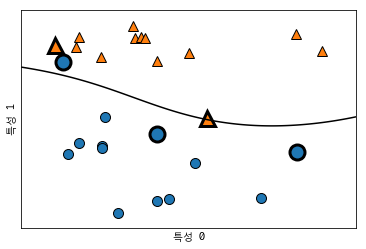

In [2]:
from sklearn.svm import SVC

X, y = mglearn.tools.make_handcrafted_dataset()                                                                  
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)                                                
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
# 데이터 포인트 그리기
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
# 서포트 벡터
sv = svm.support_vectors_
# dual_coef_ 의 부호에 의해 서포트 벡터의 클래스 레이블이 결정됩니다
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

#### SVM 매개변수 튜닝
* gamma: 가우시안 커널 폭의 역수에 해당. 하나의 훈련 샘플이 미치는 영향의 범위를 결정한다. 클수록 영향을 미치는 범위가 적어진다.
* C: 선형 모델의 규제 매개변수에 해당. 각 포인트의 중요도(`duel_coef_`값)을 제한.

각 매개변수를 다르게 했을 때 어떻게 변경되는지 확인하자.

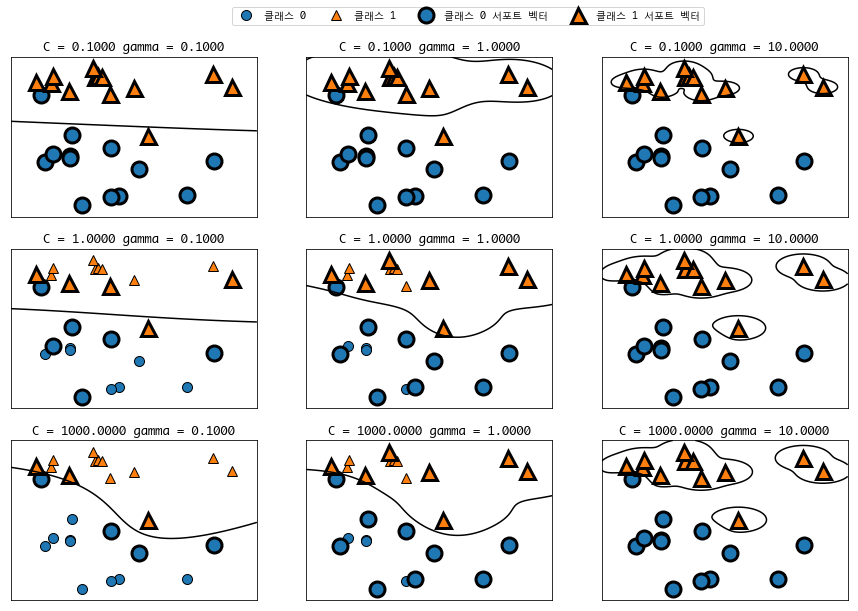

In [3]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)
        
axes[0, 0].legend(["클래스 0", "클래스 1", "클래스 0 서포트 벡터", "클래스 1 서포트 벡터"],
                  ncol=4, loc=(.9, 1.2))

감마값이 커질수록 경계가 개별 포인트에 민감해져 복잡한 모델을 만든다.

작은 C값은 제약이 큰 모델을 만들며 각 데이터 포인트의 영향력이 작다.

RBF 커널 SVM을 유방암 데이터셋에 적용한다.(기본값 C=1, gamma=1/n_features)

훈련 세트 정확도: 1.00
테스트 세트 정확도: 0.63


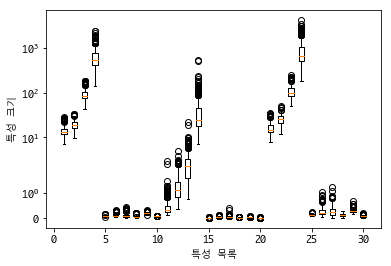

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

svc = SVC()
svc.fit(X_train, y_train)

print("훈련 세트 정확도: {:.2f}".format(svc.score(X_train, y_train)))
print("테스트 세트 정확도: {:.2f}".format(svc.score(X_test, y_test)))

plt.boxplot(X_train, manage_xticks=False)
plt.yscale("symlog")
plt.xlabel("특성 목록")
plt.ylabel("특성 크기")

훈련 세트는 100%지만 테스트 세트는 63%이기 때문에 상당히 과적합되었다. SVM은 매개변수 설정과 데이터 스케일에 매우 민감하다. 특히 입력 특성의 범위가 비슷해야 한다. 각 특성의 최솟값과 최댓값을 로그 스케일로 나타내면 각 특성들의 자릿수 자체가 다르다.

#### SVM을 위한 데이터 전처리
이 문제를 해결하는 방법 중 하나는 특성 값의 범위가 비슷해지도록 조정하는 것이다. 모든 특성 값을 0~1로 맞추는 방법을 많이 사용한다. `MinMaxScaler` 전처리 메소드를 사용할 수 있다. 여기에서는 아래 식을 통해 직접 제작한다.
$${X-\min(X) \over \max(X)-\min(X)}$$

In [7]:
# 훈련 세트에서 특성별 최솟값 계산
min_on_training = X_train.min(axis=0)
# 훈련 세트에서 특성별 (최댓값 - 최솟값) 범위 계산
range_on_training = (X_train - min_on_training).max(axis=0)

# 훈련 데이터에 최솟값을 빼고 범위로 나누면 각 특성에 대해 최솟값은 0 최댓값은 1 임
X_train_scaled = (X_train - min_on_training) / range_on_training

print("특성별 최솟값\n{}".format(X_train_scaled.min(axis=0)))
print("특성별 최댓값\n {}".format(X_train_scaled.max(axis=0)))

특성별 최솟값
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
특성별 최댓값
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [9]:
# 테스트 세트에도 같은 작업을 적용하지만
# 훈련 세트에서 계산한 최솟값과 범위를 사용합니다(자세한 내용은 3장에 있습니다)
X_test_scaled = (X_test - min_on_training) / range_on_training

svc = SVC()
svc.fit(X_train_scaled, y_train)

print("훈련 세트 정확도: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("테스트 세트 정확도: {:.3f}".format(svc.score(X_test_scaled, y_test)))

훈련 세트 정확도: 0.948
테스트 세트 정확도: 0.951


In [10]:
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)

print("훈련 세트 정확도: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("테스트 세트 정확도: {:.3f}".format(svc.score(X_test_scaled, y_test)))

훈련 세트 정확도: 0.988
테스트 세트 정확도: 0.972


데이터의 스케일을 조정하고 매개변수를 조절해서 과적합을 해결해 성능을 향상시킬 수 있다.

#### 장단점과 매개변수
* 장점: 저차원과 고차원(특성이 적거나 많을 때)에서 모두 잘 작동하고 특성이 몇 개 안 되더라도 복잡한 결정 경계를 만들 수 있다.
* 단점: 샘플이 많을 때(100,000개 이상)는 속도와 메모리 문제가 있을 수 있다. 전처리와 매개변수 설정에 민감하다. 모델을 분석하기 어렵다.
* 주요 매개변수
  * C: 규제 매개변수
  * 커널의 종류: scikit-learn에선 'rbf' (기본값), 'linear' $(x_1 \cdot x_2)$, 'poly' $(\gamma(x_1 \cdot x_2)+c)^d$, 'sigmoid' $(\tanh(\gamma(x_1 \cdot x_2)+c))$, 'precomputed' (미리 계산된 값을 사용) 등을 지원

### 신경망(딥러닝)
최근들어 딥러닝이란 이름으로 다시 주목받는 알고리즘들. 여기에서는 간단한 **다층 퍼셉트론** *multilayer perceptrons, MLP*를 다룬다. 다층 퍼셉트론은 피드포워드 신경망, 완전 연결 신경망이라고도 한다.

#### 신경망 모델
MLP는 여러 단계를 거쳐 결정을 만들어내는 선형 모델의 일반화된 모습이라고 볼 수 있다. 

선형 모델의 예측 공식은 다음과 같다.
$$ \hat{y}=w[0]\times x[0]+w[1]\times x[1]+...+w[p]\times x[p]+b $$

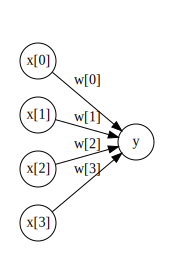

In [12]:
mglearn.plots.plot_logistic_regression_graph()

MLP에서는 가중치 합을 만드는 과정이 여러 번 반복되며, 먼저 중간 단계를 구성하는 **은닉 유닛** *hiddeen unit*을 계산하고 이를 이용해 최종 가중치 합을 계산한다. 이런 모델은 많은 계수(가중치)를 학습해야 하며 이 계수는 각 입력과 **은닉층**사이, 은닉층과 출력 사이마다 있다.

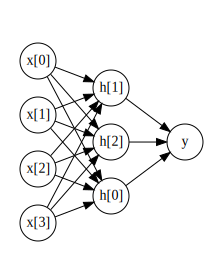

In [13]:
mglearn.plots.plot_single_hidden_layer_graph()

여러 개의 가중치 합을 계산하는 것은 수학적으로 하나의 가중치 합을 계산하는 것과 같다.(단순 선형 함수이기 때문) 선형 모델보다 강력하게 만들려면 각 은닉 유닛의 가중치 합을 계산한 후 그 결과의 비선형 함수인 **렐루** *rectified linear unit, ReLU*나 **하이퍼볼릭 탄젠트** *hyperbolic tangent, tanh*를 적용한다. 두 함수는 아래 그림과 같다. 이런 비선형 함수를 이용해 신경망이 선형 모델보다 더 복잡한 함수를 학습할 수 있다.

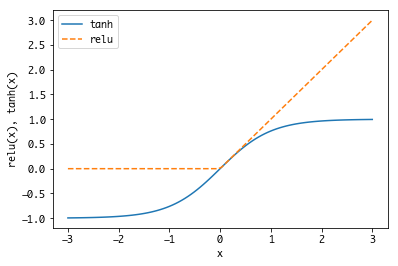

In [14]:
line = np.linspace(-3, 3, 100)
plt.plot(line, np.tanh(line), label="tanh")
plt.plot(line, np.maximum(line, 0), linestyle='--', label="relu")
plt.legend(loc="best")
plt.xlabel("x")
plt.ylabel("relu(x), tanh(x)")

위의 신경망으로 (tanh 함수를 비선형 함수로 사용해서) 회귀분석을 할 때 $\hat y$를 계산하는 전체 공식은 다음과 같다.
$$h[0]=\tanh(w[0,0] \times x[0]+w[1,0] \times x[1]+w[2,0] \times x[2]+w[3,0] \times x[3]+b[0])$$ 
$$h[1]=\tanh(w[0,1] \times x[0]+w[1,1] \times x[1]+w[2,1] \times x[2]+w[3,1] \times x[3]+b[1])$$
$$h[1]=\tanh(w[0,2] \times x[0]+w[1,2] \times x[1]+w[2,2] \times x[2]+w[3,2] \times x[3]+b[2])$$
$$\hat y=v[0] \times h[0]+v[1] \times h[1]+v[2] \times h[2]+b$$
w: 입력 x와 은닉층 h 사이의 가중치, v: 은닉층과 출력 사이의 가중치

보통 분류의 경우 신경망 마지막 출력층에 시그모이드(이진 분류)나 소프트맥스(다중 분류) 함수를 적용하여 최종출력 $\hat y$를 계산한다. 소프트맥스는 여러 유닛의 출력값을 정규화하기 위한 함수로 ${e^{z_j}\over{\sum_{i=1}^k}e^{z_i}}$와 같이 나타낸다. (z는 각 유닛의 출력값, k는 유닛 개수)

은닉층의 유닛 개수와 은닉층의 수를 정하는 것이 중요하다. 이렇게 많은 은닉층으로 구성된 대규모의 신경망이 생기면서 이를 딥러닝이라고 부르게 되었다.

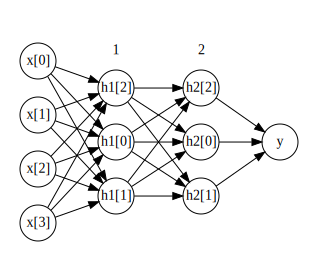

In [15]:
mglearn.plots.plot_two_hidden_layer_graph()

#### 신경망 튜닝

#### 장단점과 매개변수

#### 신경망의 복잡도 추정